In [1]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors as rdescriptors
from rdkit.Chem.Draw import IPythonConsole
import csv
import pandas
import matplotlib.pyplot as plt
from rdkit.Chem import Crippen

RDKit WARNING: [16:47:41] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
with open('chembl_dopamin_d2_rp_ki.csv', "r") as f:
    reader = csv.DictReader(f, delimiter=";")
    ligands = [Chem.MolFromSmiles(m["Smiles"]) for m in reader]

supplier = Chem.SDMolSupplier("../data/drugbank.sdf")
drugbank = [m for m in supplier if m!=None]

print(len(ligands))
print(len(drugbank))

RDKit ERROR: [16:47:45] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [16:47:45] ERROR: Could not sanitize molecule ending on line 20009
RDKit WARNING: [16:47:46] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit WARNING: [16:47:46] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit ERROR: [16:47:45] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [16:47:46] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [16:47:46] ERROR: Could not sanitize molecule ending on line 250947
RDKit ERROR: [16:47:46] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [16:47:46] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [16:47:46] ERROR: Could not sanitize molecule ending on line 258130
RDKit ERROR: [16:47:46] ERROR: Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [16:47:46] Can't kek

10473
7113


RDKit ERROR: [16:47:47] ERROR: Explicit valence for atom # 0 Be, 3, is greater than permitted
RDKit ERROR: [16:47:48] Explicit valence for atom # 0 C greater than permitted
RDKit ERROR: [16:47:48] ERROR: Could not sanitize molecule ending on line 1151592


In [3]:
#lipinski RO5
#max 5 HBD
#max 10 HBA
#mw max 500
#logp max 5

#returns true if all Lipinski rules are followed 
def conformedRO5(m):
    if(rdescriptors.CalcNumHBD(m) < 5 and rdescriptors.CalcNumHBA(m) < 10 and rdescriptors.CalcExactMolWt(m) < 500 and Descriptors.MolLogP(m) < 5):
        return "Is Lipinski approved - biologically available."
    else:
        return "Is NOT Lipinski approved - biologically UNavailable."

# returns true if more than one Lipinsky rule is broken
def moreThanOneRO5Broken(m):
    rules_broken = 0
    if rdescriptors.CalcNumHBD(m) > 5:
        rules_broken += 1
    if rdescriptors.CalcNumHBA(m) > 10:
        rules_broken += 1
    if rdescriptors.CalcExactMolWt(m) > 500:
        rules_broken += 1
    if Descriptors.MolLogP(m) > 5:
        rules_broken += 1
    return rules_broken > 1

#returns number of each misdemeanor
def numberOfViolationsLipinski(molecules):
    HBD_violations = 0
    HBA_violations = 0
    MW_violations = 0
    logP_violations = 0
    for m in molecules:
        if rdescriptors.CalcNumLipinskiHBD(m) > 5:
             HBD_violations += 1
        if rdescriptors.CalcNumLipinskiHBA(m) > 10:
            HBA_violations += 1
        if rdescriptors.CalcExactMolWt(m) > 500:
            MW_violations += 1
        if Descriptors.MolLogP(m) > 5:
            logP_violations += 1
    return [HBD_violations, HBA_violations, MW_violations, logP_violations]

#Ghose
# -0.4 < logP < 5.6
# 180 < MW < 480
# 40 < refractivity < 130
# 20 < #atoms <70

#Ghose version of combined functions numberOfViolations and moreThan...
def numberOfViolationGhose(molecules):
    logP_violations = 0
    refractivity_violations = 0
    MW_violations = 0
    atom_count_violations = 0
    ghose_violations = 0
    for m in molecules:
        rules_broken = 0
        if (Descriptors.MolLogP(m) > 5.6) or (Descriptors.MolLogP(m) < -0.4):
            logP_violations += 1
            rules_broken += 1
        if (Crippen.MolMR(m) > 130) or (Crippen.MolMR(m) < 40):
            refractivity_violations += 1
            rules_broken += 1
        if (rdescriptors.CalcExactMolWt(m) > 480) or (rdescriptors.CalcExactMolWt(m) < 180):
            MW_violations += 1
            rules_broken += 1
        if (m.GetNumHeavyAtoms() > 70) or (m.GetNumHeavyAtoms() < 20):
            atom_count_violations += 1
            rules_broken += 1
        if rules_broken > 0:
            ghose_violations += 1
    return [logP_violations, refractivity_violations, MW_violations, atom_count_violations, ghose_violations]

#Verber
# #rot.bonds < 10
# TPSA < 140

#same, just for Verber
def numberOfViolationsVerber(molecules):
    rot_bond_violations = 0
    TPSA_violations = 0
    verber_violations = 0
    for m in molecules:
        rules_broken = 0
        if Chem.CalcNumRotatableBonds(m) > 10:
            rot_bond_violations += 1
            rules_broken += 1
        if rdescriptors.CalcTPSA(m) > 140:
            TPSA_violations += 1
            rules_broken += 1
        if rules_broken > 0:
            verber_violations += 1
    return [rot_bond_violations, TPSA_violations, verber_violations]

In [4]:
def barplotter(x, y, _ylabel):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(x, y, color = "burlywood")
    ax.set_ylabel(_ylabel)#"proportion of violation"
    plt.xticks(rotation='vertical')
    plt.show()

#barplotter(rules, proportion_of_violations, "proportion of violation")

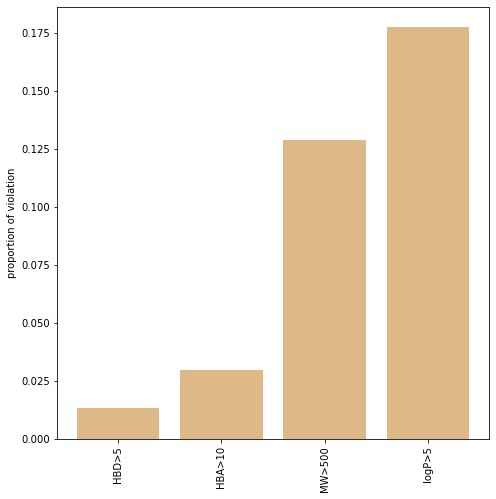

{'HBD>5': 0.013463191062732742, 'HBA>10': 0.02988637448677552, 'MW>500': 0.12880740952926573, 'logP>5': 0.17740857442948535}
celkovy # molekul 10473


In [5]:
#RO5 violations graph
rules = ["HBD>5", "HBA>10", "MW>500", "logP>5"]
violations_d2 = numberOfViolationsLipinski(ligands)
proportion_of_violations = [v/len(ligands) for v in violations_d2]
barplotter(rules, proportion_of_violations, "proportion of violation")
violations_d2_dict = dict(zip(rules, proportion_of_violations))
print(violations_d2_dict)
print("celkovy # molekul " + str(len(ligands)))

Největším problémem DD2 (dopamin d2) liganů je jejich velikost a rozdělovací koeficient (hydrofobicita). Relativní množství molekul, které porušují RO5 je u DD2 datasetu menší než u mTOR datasetu.


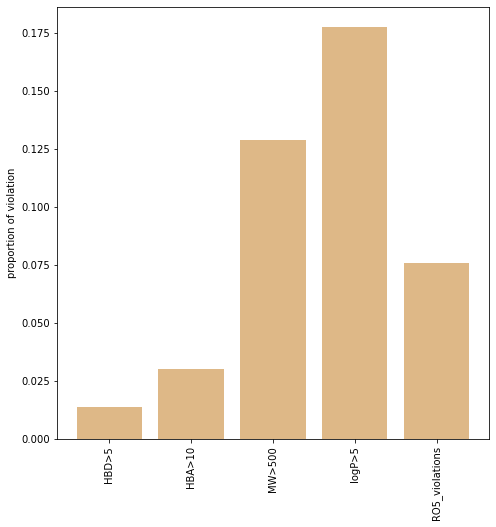

{'HBD>5': 0.013463191062732742, 'HBA>10': 0.02988637448677552, 'MW>500': 0.12880740952926573, 'logP>5': 0.17740857442948535, 'RO5_violations': 0.07590948152391865}


(3661, 0.34956554950825935, 795, 0.07590948152391865)

In [6]:
#RO5(single violation allowed) violations graph
#overall number of RO5 violations
number_of_d2_violations = sum(violations_d2)
#number of violations just one allowed
violations_d2_one_allowed = sum([moreThanOneRO5Broken(l) for l in ligands])
violations_d2_dict['RO5_violations'] = violations_d2_one_allowed/len(ligands)

barplotter(violations_d2_dict.keys(), violations_d2_dict.values(), "proportion of violation")

print(violations_d2_dict)

number_of_d2_violations, number_of_d2_violations/len(ligands), violations_d2_one_allowed, violations_d2_one_allowed/len(ligands)

Při povolení jednoho porušení RO5 je zhruba 7,5 % molekul stále porušuje, ale je to přibližně o polovinu molekul méně než u mTOR ligandů. (Nejčastějším problémem bývá velikost a hydrofobicita.)

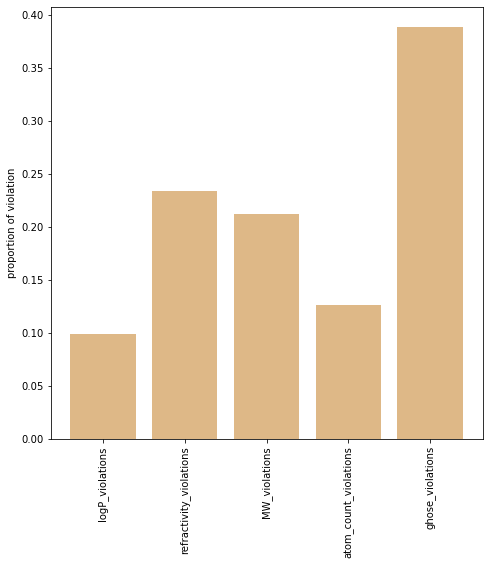

{'logP_violations': 0.09892103504249021, 'refractivity_violations': 0.23422133104172635, 'MW_violations': 0.21216461376873866, 'atom_count_violations': 0.12632483529074764, 'ghose_violations': 0.38823641745440657}


In [7]:
#Ghose graph
rules_ghose =  ["logP_violations", "refractivity_violations", "MW_violations", "atom_count_violations", "ghose_violations"]
violations_ghose = numberOfViolationGhose(ligands)
proportion_of_violations_ghose = [v/len(ligands) for v in violations_ghose]

barplotter(rules_ghose, proportion_of_violations_ghose, "proportion of violation")

violations_ghose_dict = dict(zip(rules_ghose, proportion_of_violations_ghose))
print(violations_ghose_dict)

Ghose filter vyřazuje velké molekuly (byl to problém i u Lipinského pravidel, ale ty byly mírnější). Ještě více vyřazuje molekuly podle jejich refraktivity. Naopak propustí více hydrofobnějších molekul (ligandy DD2RP jsou obecně hydrofobnější). Ale celkově je filtr přísný a vyřadí skoro 40 % molekul (méně než u mTOR, ligandy mTOR se zdají být větší než ty moje a také mají větší poblémy s filtrem na refraktivitu).

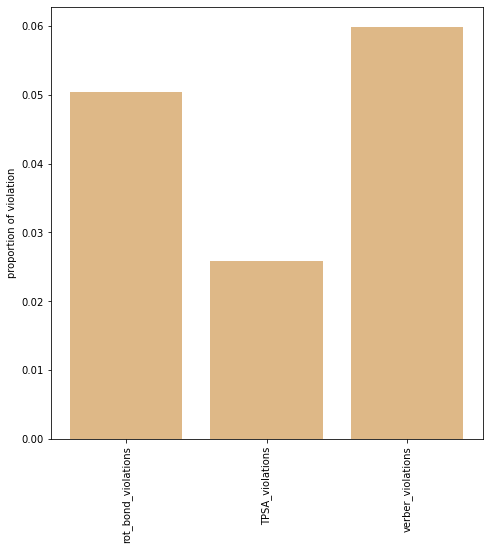

{'rot_bond_violations': 0.05041535376682899, 'TPSA_violations': 0.025876062255323212, 'verber_violations': 0.05977274897355104}


In [8]:
#Verbers violations
rules_verber = ["rot_bond_violations", "TPSA_violations", "verber_violations"]
violations_verber = numberOfViolationsVerber(ligands)
proportion_of_violations_verber = [v/len(ligands) for v in violations_verber]

barplotter(rules_verber, proportion_of_violations_verber, "proportion of violation")

violations_verber_dict = dict(zip(rules_verber, proportion_of_violations_verber))
print(violations_verber_dict)

Veberův filtr se zdá být ze všech nejméně striktní, DD2 ligandy mají větší problém s počtem rotovatelných vazeb než s TPSA (souvisí s jejich větší hydrofobicitou). Oproti mTOR ligandům mají DD2 ligandy větší počet rotovatelných vazeb, ale co ztratí na tomto pravidle doženou na menším TPSA.

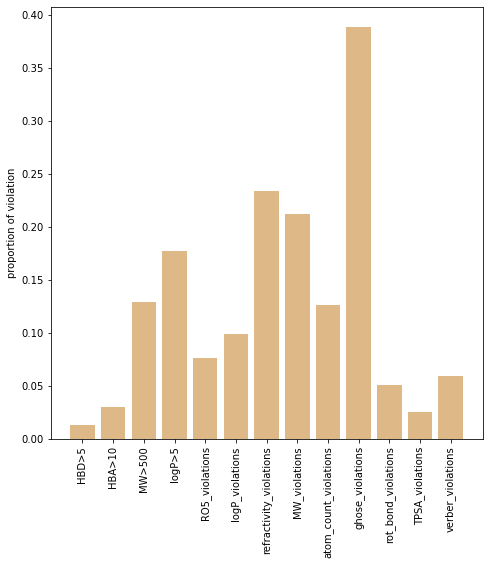

In [9]:
#everthing together dopamin
d2_violations = dict(violations_d2_dict, **violations_ghose_dict)
d2_violations.update(violations_verber_dict)

barplotter(d2_violations.keys(), d2_violations.values(), "proportion of violation")


Obecně se mi zdá DD2 dataset více "drug-like" než mTOR dataset.

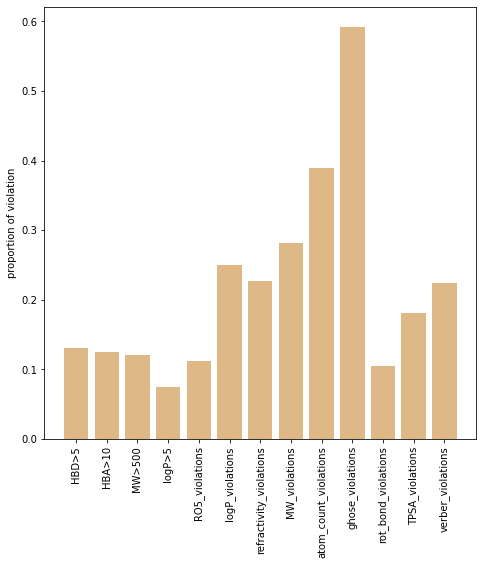

In [10]:
#drugbank data
violations_db = numberOfViolationsLipinski(drugbank)
proportion_of_violations_db = [v/len(drugbank) for v in violations_db]
number_of_db_violations = sum(violations_db)
violations_db_dict = dict(zip(rules, proportion_of_violations_db))
violations_db_one_allowed = sum([moreThanOneRO5Broken(l) for l in ligands])
violations_db_dict['RO5_violations'] = violations_db_one_allowed/len(drugbank)


violations_ghose_db = numberOfViolationGhose(drugbank)
proportion_of_violations_ghose_db = [v/len(drugbank) for v in violations_ghose_db]
violations_ghose_dict_db = dict(zip(rules_ghose, proportion_of_violations_ghose_db))

violations_verber_vb = numberOfViolationsVerber(drugbank)
proportion_of_violations_verber_db = [v/len(drugbank) for v in violations_verber_vb]
violations_verber_dict_db = dict(zip(rules_verber, proportion_of_violations_verber_db))

db_violations = dict(violations_db_dict, **violations_ghose_dict_db)
db_violations.update(violations_verber_dict_db)

barplotter(db_violations.keys(), db_violations.values(), "proportion of violation")

In [11]:
def biplotter(x1, x2, y1, y2, x1_label, x2_label, _ylabel):
    ax = plt.subplot()
    ax.bar(x1, y1, width=0.2, color="seagreen", align="edge", label = x1_label)
    ax.bar(x2, y2, width=-0.2, color="goldenrod", align="edge", label = x2_label)
    ax.set_ylabel(_ylabel)
    ax.legend()
    plt.xticks(rotation='vertical')
    plt.show
    

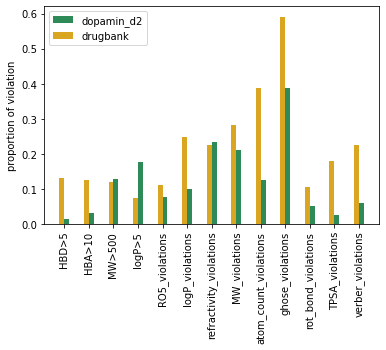

In [12]:
#db+d2
biplotter(d2_violations.keys(),db_violations.keys(), d2_violations.values(), db_violations.values(), "dopamin_d2", "drugbank", "proportion of violation")

Molekuly z drugbanku mají s většinou pravidel větší problémy než molekuly DD2. Jinak je to pouze u molekulové hmotnosti (DD2 molekuly jsou větší),
rozdělovacího koeficientu (tam je rozdíl markantní, molekuly jsou daleko více hydrofobní) a refraktivity. 

In [13]:
#lead-likeness
#logP<=3
#MW<300
#HBA<=3
#HBD<=3
#rotbond <=3
def numberOfLeadLike(molecules):
    HBD = 0
    HBA = 0
    MW = 0
    logP = 0
    rot_bond = 0
    leadlike = 0
    for m in molecules:
        number_of_leadlike_properties = 0
        if rdescriptors.CalcNumLipinskiHBD(m) < 4:
            HBD += 1
            number_of_leadlike_properties += 1
        if rdescriptors.CalcNumLipinskiHBA(m) < 4:
            HBA += 1
            number_of_leadlike_properties += 1
        if rdescriptors.CalcExactMolWt(m) < 300:
            MW += 1
            number_of_leadlike_properties += 1
        if Descriptors.MolLogP(m) <= 3:
            logP += 1
            number_of_leadlike_properties += 1
        if Chem.CalcNumRotatableBonds(m)  < 4:
            rot_bond += 1
            number_of_leadlike_properties += 1
        if number_of_leadlike_properties == 5:
            leadlike += 1
    return [HBD, HBA, MW, logP, rot_bond, leadlike]

{'HBD': 0.9567459180750502, 'HBA': 0.2620070657882173, 'MW': 0.16384989974219422, 'logP': 0.24033228301346318, 'rot_bond': 0.23918647951876254, 'leadlike': 0.05022438651771221}
{'HBD': 0.6787572051173907, 'HBA': 0.22957964290735272, 'MW': 0.4227470828061296, 'logP': 0.6648390271334177, 'rot_bond': 0.3867566427667651, 'leadlike': 0.09869253479544496}


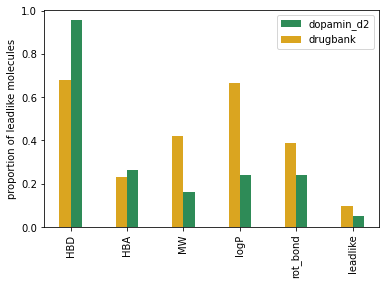

In [14]:
#dopamin d2 ligands
leadlikness_d2 = numberOfLeadLike(ligands)
proportion_of_leadlike_d2 = [v/len(ligands) for v in leadlikness_d2]
leadlikness_dict_d2= dict(zip(["HBD", "HBA", "MW", "logP", "rot_bond", "leadlike"], proportion_of_leadlike_d2))
print(leadlikness_dict_d2)

#ligands from drugbank
leadlikness_db = numberOfLeadLike(drugbank)
proportion_of_leadlike_db = [v/len(drugbank) for v in leadlikness_db]
leadlikness_dict_db= dict(zip(["HBD", "HBA", "MW", "logP", "rot_bond", "leadlike"], proportion_of_leadlike_db))
print(leadlikness_dict_db)

biplotter(leadlikness_dict_d2.keys(),leadlikness_dict_db.keys(), leadlikness_dict_d2.values(), leadlikness_dict_db.values(), "dopamin_d2", "drugbank", "proportion of leadlike molecules")

DD2 dataset neobsahuje moc slibných lead-like molekul (?vedoucích struktur?). Molekuly jsou velké, moc hydrofobní, mají moc rotovatelných vazeb a akceptorů vodíkové vazby. Skoro všechny molekuly (95 %) mají vhodný počet donorů vodíkové vazby. Počet lead-like molekul v drugbank je téměř dvakrát větší než u DD2, ale k mému údivu ani těchto molekul není mnoho (~10 %). (Asi proto, že drugbank už obsahuje "hotová" léčiva - leadlike molekula bude na začátku řetězce návrhu, různě se upravuje, drugbank bude obsahovat molekuly až z konce řetězce návrhu.) Na rozdíl od DD2 molekul ale mají prohřešky proti lead-like pravidlům "rovnoměrnější".